### Bike Sharing Demand dataset


Forecast use of a city bikeshare system

https://www.kaggle.com/competitions/bike-sharing-demand/overview

Inspiration: https://www.kaggle.com/code/werooring/ch6-eda


#### Data Fields

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather:
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals



### Training procedure

1) Extract various features  
2) Split train.csv dataset $\rightarrow$ train/val datasets  
3) Train a model  
4) Evaluate performance  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

### Features engineering

In [4]:
def split_datetime(df):
    dt_column = df['datetime']
    seconds = dt_column.second
    minutes = dt_column.minute
    hours = dt_column.hour
    days = dt_column.day
    monthes = dt_column.month
    years = dt_column.year
    weekdays = dt_column.dayofweek
    return (seconds, minutes, hours, days, monthes, years, weekdays)

In [5]:
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])

train_df[['second', 'minute', 'hour', 'day', 'month', 'year', 'weekday']] = train_df.apply(split_datetime, axis=1, result_type="expand")
test_df[['second', 'minute', 'hour', 'day', 'month', 'year', 'weekday']] = test_df.apply(split_datetime, axis=1, result_type="expand")


season_mapping = {1: 'Spring', 
                  2: 'Summer', 
                  3: 'Fall', 
                  4: 'Winter'}
weather_mapping = {1: 'Clear', 
                   2: 'Mist, Few clouds', 
                   3: 'Light Snow, Rain, Thunder',
                   4: 'Heavy Snow, Rain, Thunder'}
weekday_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 
                   3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}


train_df['season_str'] = train_df['season'].map(season_mapping)
train_df['weather_str'] = train_df['weather'].map(weather_mapping)
test_df['season_str'] = test_df['season'].map(season_mapping)
test_df['weather_str'] = test_df['weather'].map(weather_mapping)

train_df['weekday_str'] = train_df['weekday'].map(weekday_mapping)
test_df['weekday_str'] = test_df['weekday'].map(weekday_mapping)

- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius

$delta\_temp\_atemp = atemp - temp$

- mean delta
- mean wind speed
- is_windy
- is_high_delta

In [82]:
train_df['delta_temp_atemp'] = train_df['atemp'] - train_df['temp']
test_df['delta_temp_atemp'] = test_df['atemp'] - test_df['temp']

mean_delta = train_df['delta_temp_atemp'].mean()

train_df['is_high_delta'] = train_df['delta_temp_atemp'] > mean_delta
test_df['is_high_delta'] = test_df['delta_temp_atemp'] > mean_delta

mean_wind_speed = train_df['windspeed'].mean()

train_df['is_windy'] = train_df['windspeed'] > mean_wind_speed
test_df['is_windy'] = test_df['windspeed'] > mean_wind_speed

train_df['delta_and_wind'] = train_df['is_high_delta'] & train_df['is_windy']
test_df['delta_and_wind'] = test_df['is_high_delta'] & test_df['is_windy']

### Hyperparameters

In [83]:
SEED = 32
TEST_SIZE = 0.2
FEATURE_SET = {'season', 'holiday', 'workingday', 'weather', 'temp', 
               'atemp', 'humidity', 'windspeed', 'year', 'month', 
               'day', 'hour', 'minute', 'second', 'delta_bigger_5', 'delta_temp_atemp'}
TARGET_SET = {'casual', 'registered', 'count'}
TARGET_COL = 'count'

np.random.seed(SEED) # specify seed to use for numpy

In [84]:
from sklearn.model_selection import train_test_split


X, y = train_df[FEATURE_SET], train_df[TARGET_COL]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

In [85]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error 
regression_metrics = {
    'R2': r2_score,
    'MAE': mean_absolute_error,
    'MSE': mean_squared_error,
    'MAPE': mean_absolute_percentage_error
}

In [92]:
models_preds = {}

In [93]:
from sklearn.linear_model import LinearRegression


model = LinearRegression() # no random state
model.fit(X_train, y_train)
preds = model.predict(X_val)
print(f'Model [{model.__class__.__name__}]')

for metric_name, metric in regression_metrics.items():
    metric_value = metric(y_val, preds)
    print(f'\t[{metric_name}] = [{metric_value:.4f}]')
    
models_preds['linreg'] = preds

Model [LinearRegression]
	[R2] = [0.4010]
	[MAE] = [104.6610]
	[MSE] = [19595.0052]
	[MAPE] = [3.2392]


In [94]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=SEED)
model.fit(X_train, y_train)
preds = model.predict(X_val)
print(f'Model [{model.__class__.__name__}]')

for metric_name, metric in regression_metrics.items():
    metric_value = metric(y_val, preds)
    print(f'\t[{metric_name}] = [{metric_value:.4f}]')
    
models_preds['random_forest'] = preds

Model [RandomForestRegressor]
	[R2] = [0.9453]
	[MAE] = [26.8011]
	[MSE] = [1790.5966]
	[MAPE] = [0.3111]


In [95]:
from xgboost import XGBRegressor

model = XGBRegressor(random_state=SEED)
model.fit(X_train, y_train)
preds = model.predict(X_val)
print(f'Model [{model.__class__.__name__}]')

for metric_name, metric in regression_metrics.items():
    metric_value = metric(y_val, preds)
    print(f'\t[{metric_name}] = [{metric_value:.4f}]')
    
models_preds['xgboost'] = preds

Model [XGBRegressor]
	[R2] = [0.9502]
	[MAE] = [26.6685]
	[MSE] = [1628.6021]
	[MAPE] = [0.3970]


In [96]:
import catboost as cb

model = cb.CatBoostRegressor(verbose=False, random_state=SEED)
model.fit(X_train, y_train)
preds = model.predict(X_val)
print(f'Model [{model.__class__.__name__}]')

for metric_name, metric in regression_metrics.items():
    metric_value = metric(y_val, preds)
    print(f'\t[{metric_name}] = [{metric_value:.4f}]')

models_preds['catboost'] = preds

Model [CatBoostRegressor]
	[R2] = [0.9559]
	[MAE] = [24.7583]
	[MSE] = [1443.8125]
	[MAPE] = [0.3791]


## Performance study

- model mistakes vs reality show
- what plots look like on hourly basis in average
- differentiation by month/season performance

In [106]:
models_preds_df = pd.DataFrame(models_preds)
models_preds_df.index = X_val.index
val_df = pd.concat([X_val, y_val, models_preds_df], axis=1)

[Text(0.5, 1.0, 'CatBoost vs true')]

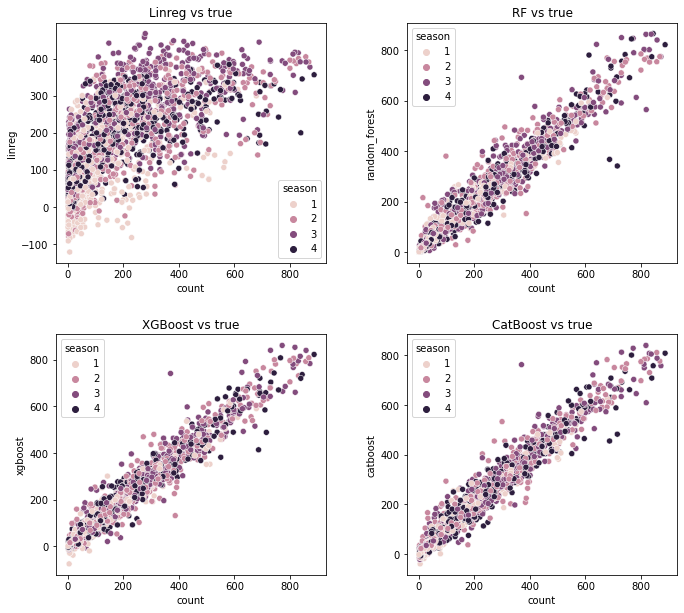

In [121]:
figure, axes = plt.subplots(nrows=2, ncols=2) 
plt.tight_layout()            
figure.set_size_inches(10, 9) 


sns.scatterplot(x='count', y='linreg', data=val_df, ax=axes[0, 0], hue="season")
sns.scatterplot(x='count', y='random_forest', data=val_df, ax=axes[0, 1], hue="season")
sns.scatterplot(x='count', y='xgboost', data=val_df, ax=axes[1, 0], hue="season")
sns.scatterplot(x='count', y='catboost', data=val_df, ax=axes[1, 1], hue="season")

axes[0, 0].set(title='Linreg vs true')
axes[0, 1].set(title='RF vs true')
axes[1, 0].set(title='XGBoost vs true')
axes[1, 1].set(title='CatBoost vs true')

In [107]:
val_df

,minute,workingday,season,delta_temp_atemp,hour,day,atemp,second,humidity,windspeed,...,temp,holiday,month,delta_bigger_5,weather,count,linreg,random_forest,xgboost,catboost
767,0,1,1,0.830,9,15,9.850,0,29,30.0026,...,9.02,0,2,False,1,110,95.855789,124.50,133.439499,117.099032
1198,0,1,1,4.055,16,14,20.455,0,35,7.0015,...,16.40,0,3,False,1,107,195.049935,128.79,115.799240,128.000084
3887,0,1,3,2.675,0,13,27.275,0,88,7.0015,...,24.60,0,9,False,1,26,53.768414,32.54,37.451447,35.777645
1306,0,0,1,4.055,7,19,20.455,0,50,22.0028,...,16.40,0,3,False,1,13,105.615243,33.89,21.540655,8.270139
9061,0,0,3,4.125,22,19,29.545,0,78,11.0014,...,25.42,0,8,False,2,56,326.382823,175.72,151.822800,146.250722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348,0,0,2,3.875,18,5,32.575,0,58,7.0015,...,28.70,0,6,False,1,363,260.148292,335.66,341.729523,347.276056
2232,0,1,2,3.740,22,19,24.240,0,82,19.9995,...,20.50,0,5,False,3,79,181.229067,91.44,99.697975,105.071962
3714,0,0,3,3.940,16,5,31.820,0,79,19.0012,...,27.88,1,9,False,2,284,213.176547,298.48,282.296692,303.008280
2389,0,1,2,3.690,11,7,34.850,0,52,16.9979,...,31.16,0,6,False,2,151,233.935210,146.60,144.120895,147.645400


In [105]:
models_preds_df

,linreg,random_forest,xgboost,catboost
0,95.855789,124.50,133.439499,117.099032
1,195.049935,128.79,115.799240,128.000084
2,53.768414,32.54,37.451447,35.777645
3,105.615243,33.89,21.540655,8.270139
4,326.382823,175.72,151.822800,146.250722
...,...,...,...,...
2173,260.148292,335.66,341.729523,347.276056
2174,181.229067,91.44,99.697975,105.071962
2175,213.176547,298.48,282.296692,303.008280
2176,233.935210,146.60,144.120895,147.645400
